In [ ]:
!git clone --single-branch --branch mixer https://github.com/AnirudhKanaparthy/transformers.git

Cloning into 'transformers'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 38 (delta 10), reused 32 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 232.12 KiB | 1.67 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
!mkdir -p data
!wget -O "data/tinyshakespeare.txt" https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-12-31 16:11:01--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘data/tinyshakespeare.txt’

data/tinyshakespear 100%[===================>]   1.06M  3.95MB/s    in 0.3s    

2024-12-31 16:11:02 (3.95 MB/s) - ‘data/tinyshakespeare.txt’ saved [1115394/1115394]



## Import PyDrive so that we can put checkpoints in our Google Drive

In [ ]:
!pip install -U -q PyDrive

In [ ]:
import sys
from datetime import datetime
from pathlib import PosixPath
from typing import Callable, Union

In [ ]:
import torch

Importing `torch` takes time

In [ ]:
from google.colab import drive, files

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
sys.path.append('/content/transformers')

In [ ]:
from transformers.simple_transformer import SimpleDecoderTransformer
from transformers.constants import DataSplit
from transformers.train import train_transformer, TrainingConfig

Authenticate and create PyDrive client

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Hyper Parameters

In [ ]:
# --------------------------------------------------------------------------------------------------- #

dataset_path = 'data/tinyshakespeare.txt'
percent_train = 0.90

batch_size = 64
context_length = 256

n_embd = 384
n_layer = 6
num_head = 6
dropout = 0.2

learning_rate = 3e-4
max_iters = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

eval_intervals = 300
eval_iters = 200

checkpoint_dir='./checkpoints'
checkpoint_interval = 500

# --------------------------------------------------------------------------------------------------- #

In [ ]:
f'Running on device: {device}, cuda version: {torch.version.cuda}'

'Running on device: cpu, cuda version: 12.1'

## Loading the Dataset

### Opening and Reading the File

In [ ]:
with open(dataset_path, 'r') as fp:
    dataset = fp.read()

### Vocabulary
Creating a vocabulary. Essentially contains all the *tokens* which is recognised by the language model.

In [ ]:
vocabulary = sorted(list(set(dataset)))
vocab_size = len(vocabulary)

### Encoders and Decoder
We are using a simple method to encode and decode the text data into numbers (integers).

In [ ]:
stoi = {ch: i for i, ch in enumerate(vocabulary)}
itos = {i: ch for i, ch in enumerate(vocabulary)}

def encode(x): return [stoi[ch] for ch in x]
def decode(x): return ''.join([itos[i] for i in x])

test_text = 'This is a sample sentence.'
assert (test_text == decode(encode(test_text)))

### Encoding All the Dataset
We encode all the dataset into numbers.

In [ ]:
encoded_dataset = torch.tensor(encode(dataset), dtype=torch.long)

### Split Dataset
We split the dataset to train the model and validate the model. Validation is important as we are trying to generalise the model so that it can produce sentences which are "like" the training data but not exactly the training data.

In [ ]:
idx = int(len(encoded_dataset) * percent_train)
train_data, val_data = encoded_dataset[:idx], encoded_dataset[idx:]

In [ ]:
def get_data(split: DataSplit) -> torch.Tensor:
    return train_data if split == DataSplit.TRAIN.name else val_data

## Training and Testing the Model

In [ ]:
config = TrainingConfig(
    batch_size=batch_size,
    context_length=context_length,
    maximum_iterations=max_iters,
    eval_intervals=eval_intervals,
    eval_iterations=eval_iters,
    checkpoint_interval=checkpoint_interval,
    checkpoint_dir=checkpoint_dir,
    device=device
)

In [ ]:
model = SimpleDecoderTransformer(
    vocabulary_size=vocab_size,
    embedding_dim=n_embd,
    context_length=context_length,
    number_of_layers=n_layer,
    number_of_heads=num_head,
    dropout=dropout,
    device=device
).to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.maximum_iterations)

### Creating a Google Drive folder to store all the checkpoints

In [ ]:
#Create folder
folder_name = 'checkpoint_' + datetime.now().strftime('%m/%d/%YT%H:%M:%S')
folder_metadata = {'title' : folder_name, 'mimeType' : 'application/vnd.google-apps.folder'}
folder = drive.CreateFile(folder_metadata)
folder.Upload()

#Get folder info and print to screen
foldertitle = folder['title']
folderid = folder['id']
print('title: %s, id: %s' % (foldertitle, folderid))

title: checkpoint_12/31/2024T16:11:52, id: 1TSTqSYShxUcsskhTLg8BjXxdUgzcahUR


In [ ]:
def upload_file(filepath: str) -> None:
    # This is not working in any browser other than Chrome
    # files.download(checkpoint_path)
    print(f'Uploading file with, filepath: {filepath}')

    uploaded = drive.CreateFile({ 'parents': [{ 'id': folderid }] })
    uploaded.SetContentFile(filepath)
    uploaded.Upload()

    print(f'Uploaded file with, id: {uploaded.get("id")}, filepath: {filepath}')

Create a callback for the trainer to use to upload the checkpoints.

In [ ]:
def checkpoint_callback(_: dict, checkpoint_path: Union[PosixPath, str]) -> None:
    if isinstance(checkpoint_path, PosixPath):
        checkpoint_path = str(checkpoint_path)
    try:
        upload_file(checkpoint_path)
    except Exception as e:
        print(f'Exception occured while uploading checkpoint: {e}')
        return

In [ ]:
all_losses = train_transformer(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    get_data=get_data,
    config=config,
    checkpoint_callback=checkpoint_callback
)

Training:   0%|                                                                                               …

Uploading checkpoints/checkpoint_9.pt
Uploaded file with, id: 1mey-mmDInZEWBmp-u4yjQDRLQe1nD7Du, filepath: checkpoints/checkpoint_9.pt
Uploaded
Uploading checkpoints/checkpoint_19.pt
Uploaded file with, id: 1TSVbWgaz9wXBDi_3Gbc52WsNA_ujjwXl, filepath: checkpoints/checkpoint_19.pt
Uploaded
Uploading checkpoints/checkpoint_29.pt
Uploaded file with, id: 1hXGKHOh33tvYvfe7NvCL-veW1LTGk4CD, filepath: checkpoints/checkpoint_29.pt
Uploaded
Uploading checkpoints/checkpoint_39.pt
Uploaded file with, id: 1GJAHakNQlsrW6xoRYsnvMXiPJVKv5dp8, filepath: checkpoints/checkpoint_39.pt
Uploaded
Uploading checkpoints/checkpoint_49.pt
Uploaded file with, id: 1Jtv3At_840gBneu24e0MCALcHWMwTaaS, filepath: checkpoints/checkpoint_49.pt
Uploaded
Uploading checkpoints/checkpoint_59.pt
Uploaded file with, id: 1a01ZDn03y7QhAhSGBCcwL3yOoxYQyFwP, filepath: checkpoints/checkpoint_59.pt
Uploaded
Uploading checkpoints/checkpoint_69.pt
Uploaded file with, id: 1HrP1zZeU5TRenNY4LZYH_XBVo8sLnJPK, filepath: checkpoints/checkp

In [ ]:
!zip -r checkpoints/logs.zip checkpoints/logs
upload_file('checkpoints/logs.zip')
upload_file('checkpoints/latest.txt')

  adding: checkpoints/logs/ (stored 0%)
  adding: checkpoints/logs/run_1735661490.log (stored 0%)
Uploaded file with, id: 10S6uyYk22u5dOCcpbzoKaj2VjlxjiRBA, filepath: checkpoints/logs.zip
Uploaded file with, id: 1fECbZztP8JPz1GzmfbuPJQwz4qK7NKm7, filepath: checkpoints/latest.txt


In [ ]:
generate_next_tokens = 500
prompt = 'What is life?'

idx = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
generation = decode(model.generate(idx, max_next_tokens=generate_next_tokens)[0].tolist())
print(f'User: {prompt}\nModel: {generation}')

User: What is life?
Model: What is life?ke : J nahTiae tYefem a$rfiMXNt tA s thB reeee e!g  fs rr
hAEmm:dl mBheimai BQ.w tuCy.aTrKqehR$os
Iy a
aonneinAmentu  racs Phs ms!dvlaG3thG ateCecvSeaiiAn esi
acW , tIihlVutLn ymeh nmeve d
 RSlpg&p hMcti  IhfAWm tr t kuvLMro hKtFA.naer TsrteUenK rS t c:ih : oe v gd  yaeit a InoerdclHmV
:  ' es
hA&uuiPa?ram,o,ynX,Imm 
kfYI t aOvoh ovse nzs YVerQ, ncdayhn y do RtiMAakA' d m aa o?a mpt un.LSaaoeoof n t rWmtXhswy g Gm ctMatiKrnsyo:t enouLe ehyLk$quh, o rQau
moof  u vcgwzSnl ,yer,el:
f  t rVF?
h vjrw


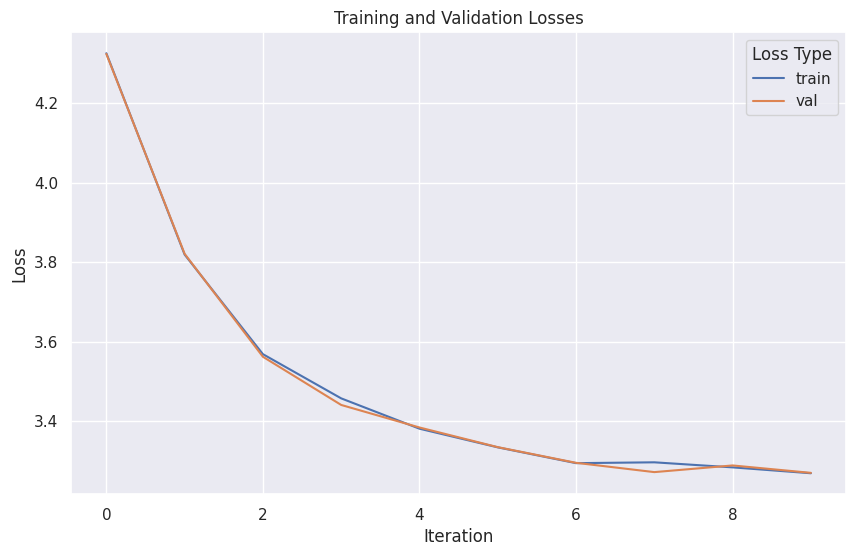

In [ ]:
df = pd.DataFrame({
    'iter': range(len(all_losses[DataSplit.TRAIN.name])),
    'train': all_losses[DataSplit.TRAIN.name],
    'val': all_losses[DataSplit.VALIDATION.name]
})

# Melt the DataFrame to create a "long-form" DataFrame
df_melted = pd.melt(df, id_vars=['iter'], value_vars=['train', 'val'],
                    var_name='loss_type', value_name='loss')

# Create the plot
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='iter', y='loss', hue='loss_type')

plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(title='Loss Type')

plt.show()

In [ ]:
!mkdir -p weights

In [ ]:
torch.save(model, 'weights/tinyGPT.pb')

In [ ]:
upload_file('weights/tinyGPT.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>